In [20]:
import sys
sys.path.append("..")
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader
from earlyrnn import EarlyRNN
import torch
from tqdm import tqdm
from loss import EarlyRewardLoss
import sklearn.metrics
import pandas as pd
import wandb
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times, plot_spectral_bands
from utils.doy import get_doys_dict_test, get_doy_stop, create_sorted_doys_dict_test, get_approximated_doys_dict
from utils.helpers_training import parse_args, train_epoch
from utils.metrics import harmonic_mean_score
import matplotlib.pyplot as plt
from models.model_helpers import count_parameters
import seaborn as sns
PALETTE=sns.color_palette("colorblind")


In [2]:
data_path = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
dataset = "breizhcrops"
sequence_length = 150
dataroot = os.path.join(data_path,"breizhcrops")
nclasses = 9
input_dim = 13
print("get doys dict test")
doys_dict_test = get_doys_dict_test(dataroot=os.path.join(data_path,dataset))
length_sorted_doy_dict_test = create_sorted_doys_dict_test(doys_dict_test)
print("get doys dict test done")
print("get train and validation data...")
test_ds = BreizhCrops(root=dataroot,partition="eval", sequencelength=sequence_length, return_id=True)
class_names = test_ds.ds.classname
print("class names:", class_names)

get doys dict test
get doys dict test done
get train and validation data...
1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [00:46<00:00, 2625.98it/s]

class names: ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


Sample 6032441 has label permanent meadows


(<Figure size 1500x700 with 1 Axes>, <Axes: xlabel='Day of year'>)

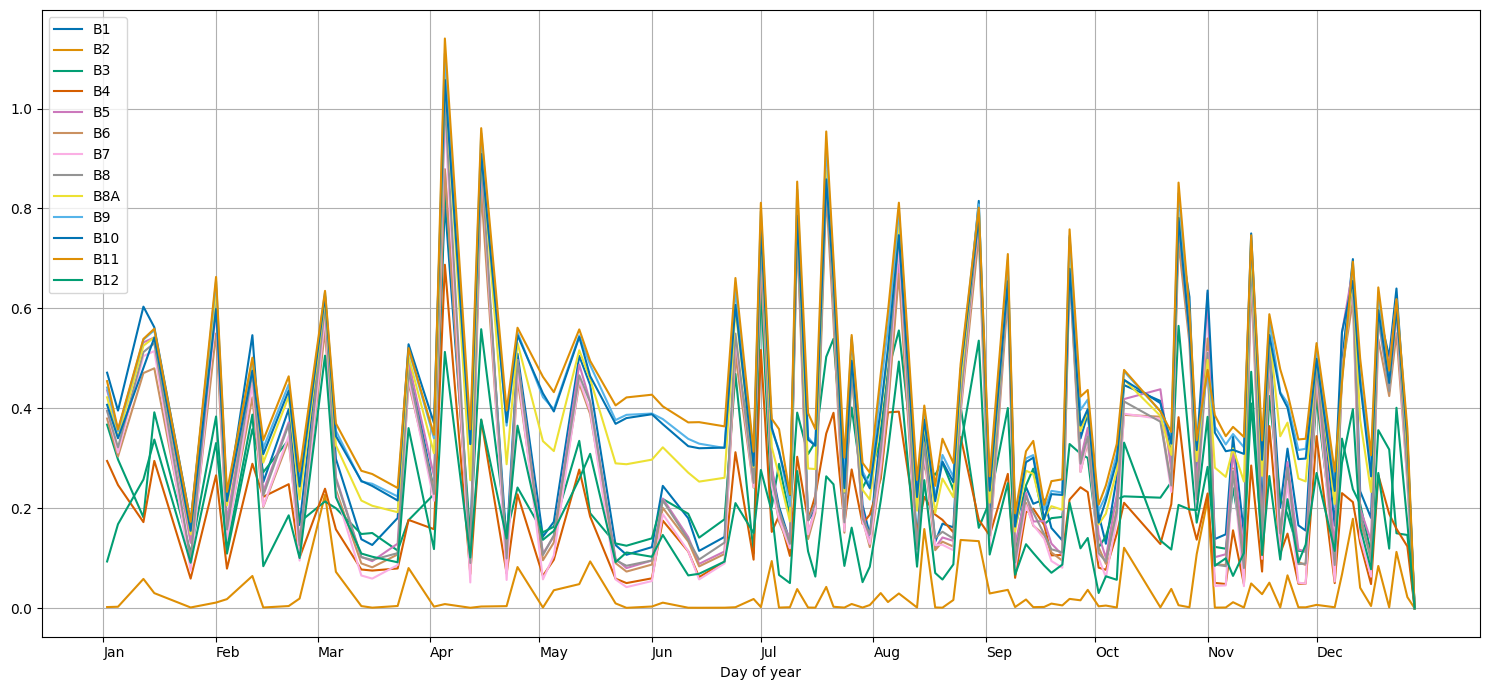

In [3]:
fig, ax = plt.subplots(figsize=(15,7))
idx = 11498
plot_spectral_bands(idx, test_ds, doys_dict_test, class_names, fig, ax)


Sample 6032238 has label corn


(<Figure size 1500x700 with 1 Axes>, <Axes: xlabel='Day of year'>)

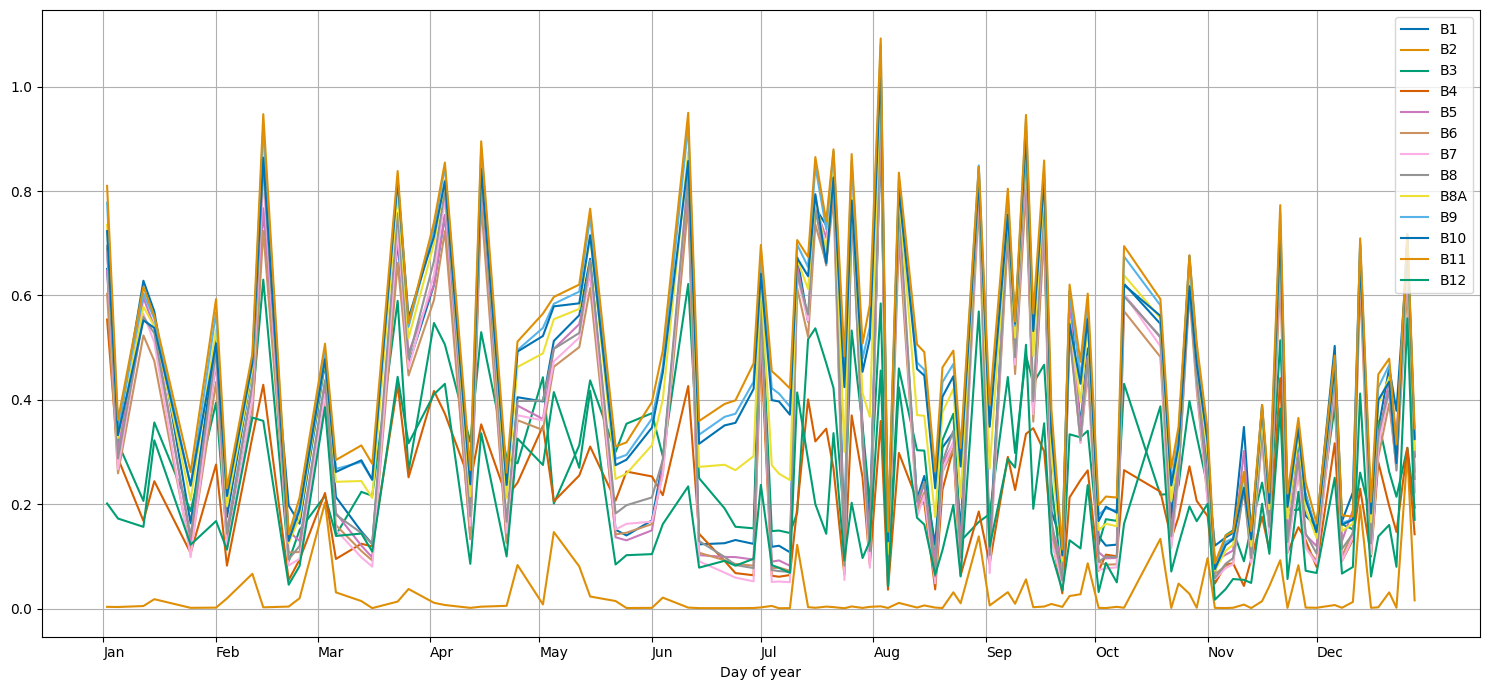

In [4]:
fig, ax = plt.subplots(figsize=(15,7))
idx = 11345
plot_spectral_bands(idx, test_ds, doys_dict_test, class_names, fig, ax)

## Count number of parcels per dataset

In [5]:
print("test_ds length:", len(test_ds))

test_ds length: 122614


In [6]:
train_ds = BreizhCrops(root=dataroot,partition="train", sequencelength=sequence_length, return_id=True)
print("train_ds length:", len(train_ds))

2559635960 2559635960


loading data into RAM: 100%|██████████| 178613/178613 [01:09<00:00, 2584.77it/s]


2253658856 2253658856


loading data into RAM: 100%|██████████| 140645/140645 [00:55<00:00, 2536.03it/s]


train_ds length: 319258


In [7]:
valid_ds = BreizhCrops(root=dataroot,partition="valid", sequencelength=sequence_length, return_id=True)
print("valid_ds length:", len(valid_ds))

2493572704 2493572704


loading data into RAM: 100%|██████████| 166391/166391 [01:02<00:00, 2653.79it/s]

valid_ds length: 166391


In [8]:
# sum of all the samples:
print("sum of all samples:", len(train_ds)+len(valid_ds)+len(test_ds))

sum of all samples: 608263


## Plot distribution of sequence length

In [11]:
from utils.doy import get_doy_stop, get_doys_dict_test

dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
doys_dict = get_doys_dict_test(dataroot=dataroot)

In [16]:
# go through all the test samples and get the index
lengths = []
for _, _, idx in test_ds: 
    length = len(doys_dict[idx])
    lengths.append(length)

In [34]:
all_lengths = []
datasets_dict = {"train": train_ds, "valid": valid_ds, "test": test_ds}
for name, ds in datasets_dict.items():
    print(f"dataset: {name}")
    temp_lengths = []
    for X, _, idx in ds:
        # if the idx is not in the doys_dict, then the length is computed as the number of non zero elements in X
        if idx not in doys_dict:
            length = (X[:,0] != 0).sum().item()
        else:
            length = len(doys_dict[idx])
        temp_lengths.append(length)
    all_lengths.append(temp_lengths)
    print(f"min: {min(temp_lengths)}, max: {max(temp_lengths)}, mean: {sum(temp_lengths)/len(temp_lengths)}")   

dataset: train
min: 50, max: 103, mean: 84.33494227239412
dataset: valid
min: 49, max: 103, mean: 85.86884506974536
dataset: test
min: 49, max: 104, mean: 69.56733325721369


Text(0.5, 1.0, 'Histogram of sequence lengths')

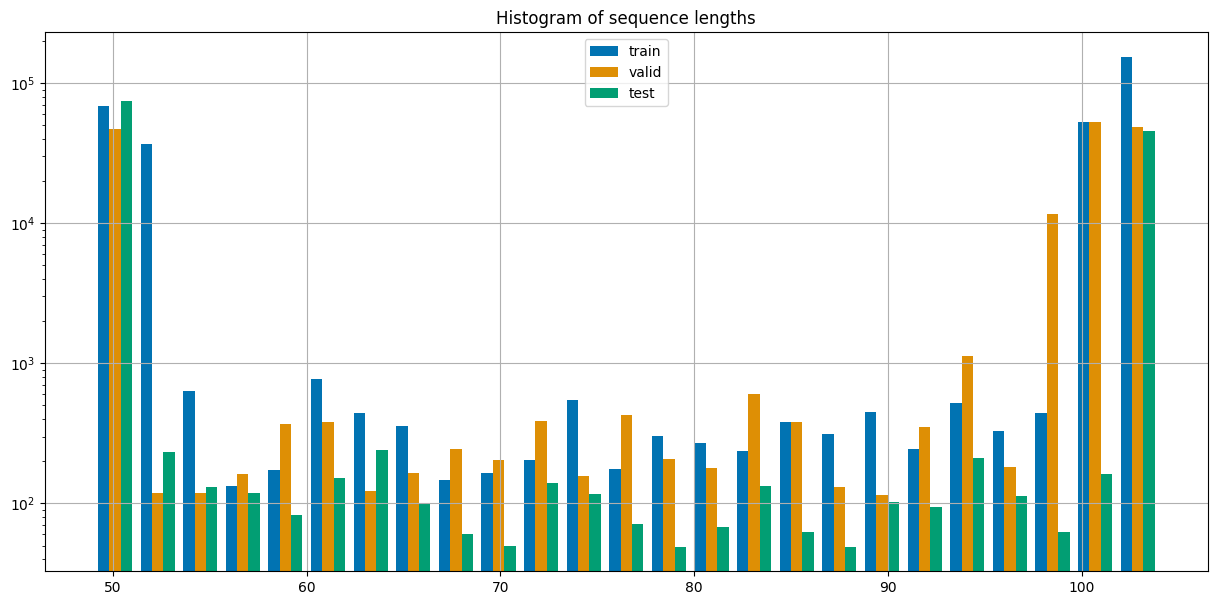

In [50]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist(all_lengths, bins=25, label=["train", "valid", "test"], histtype="bar", color=PALETTE[0:3], log=True)
ax.legend()
ax.grid()
ax.set_title("Histogram of sequence lengths")

In [41]:
len(all_lengths)

3

# Spectral signal with respect to the label and time

In [59]:
import datetime
doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13)]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]


In [68]:
data = []

for X, y, idx in test_ds: 
    doys = doys_dict[idx]
    data.append({"idx": idx, "X": X, "y": y[0], "doys": doys})

In [69]:
df = pd.DataFrame(data)
df['X'] = df['X'].apply(lambda x: x.numpy()) 
df['y'] = df['y'].apply(lambda x: x.numpy())

In [91]:
df.head()
print("shape of X:", df['X'][0].shape)

shape of X: (150, 13)


In [109]:
import numpy as np

def get_mean_std_per_day(df: pd.DataFrame, label_y: int, band: int):
    df_label = df[df['y'] == label_y]
    max_doys_value = max([max(x) for x in df_label['doys']])
    mean_std_per_day = []
    for day in range(0, max_doys_value):
        # get a dataframe with all the samples that have the day in their doys and get the band of X instead of the whole X
        df_day = df_label[df_label['doys'].apply(lambda x: day in x)]
        if len(df_day) > 0:
            # get the band of the X
            X_day = df_day['X'].apply(lambda x: x[:,band]).values
            # get the indices of the day in the doys
            indices_day = df_day.doys.apply(lambda x: np.where(x==day)[0])
            # given the indices of the day (indices_day), compute the mean and std of X_day at those indices
            indices_day = np.concatenate(indices_day.values)
            band_at_day = [x[indices_day[i]] for i, x in enumerate(X_day)]
            mean = np.mean(band_at_day)
            std = np.std(band_at_day)
            mean_std_per_day.append({"day": day, "mean": mean, "std": std})
    return mean_std_per_day


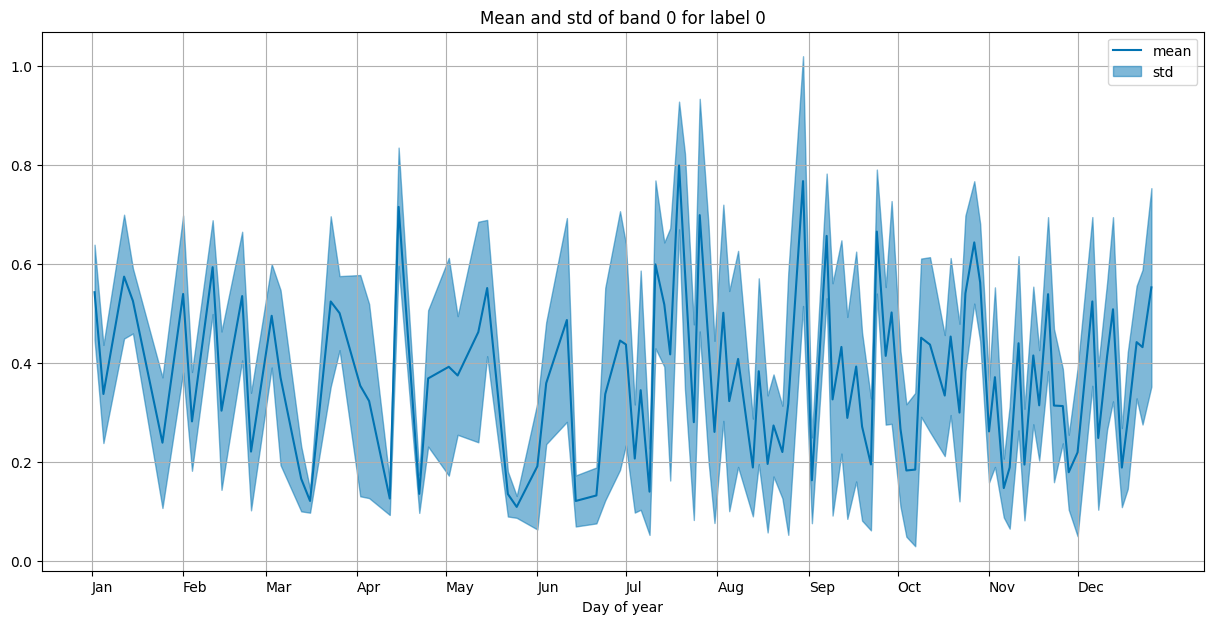

In [115]:
# from mean_std_per_day, plot the mean and std of the band for each day
def plot_mean_std_per_day(mean_std_per_day, label_y, band, fig, ax, label_string="", color=PALETTE[0], alpha=0.5):
    ax.plot([x["day"] for x in mean_std_per_day], [x["mean"] for x in mean_std_per_day], label="mean"+label_string, color=color)
    ax.fill_between([x["day"] for x in mean_std_per_day], [x["mean"]-x["std"] for x in mean_std_per_day], [x["mean"]+x["std"] for x in mean_std_per_day], alpha=alpha, label="std"+label_string, color=color)
    ax.legend()
    ax.grid()
    ax.set_title(f"Mean and std of band {band} for label {label_y}")
    ax.set_xticks(doys_months)
    ax.set_xticklabels(months, ha="left")
    ax.set_xlabel("Day of year")
    return fig, ax 

fig, ax = plt.subplots(figsize=(15,7))
label_y = 0
band = 0
mean_std_per_day = get_mean_std_per_day(df, label_y, band)
fig, ax = plot_mean_std_per_day(mean_std_per_day, label_y, band, fig, ax)


computing for label: 0 (class: barley)
computing for label: 1 (class: wheat)
computing for label: 2 (class: rapeseed)
computing for label: 3 (class: corn)
computing for label: 4 (class: sunflower)
computing for label: 5 (class: orchards)
computing for label: 6 (class: nuts)
computing for label: 7 (class: permanent meadows)
computing for label: 8 (class: temporary meadows)


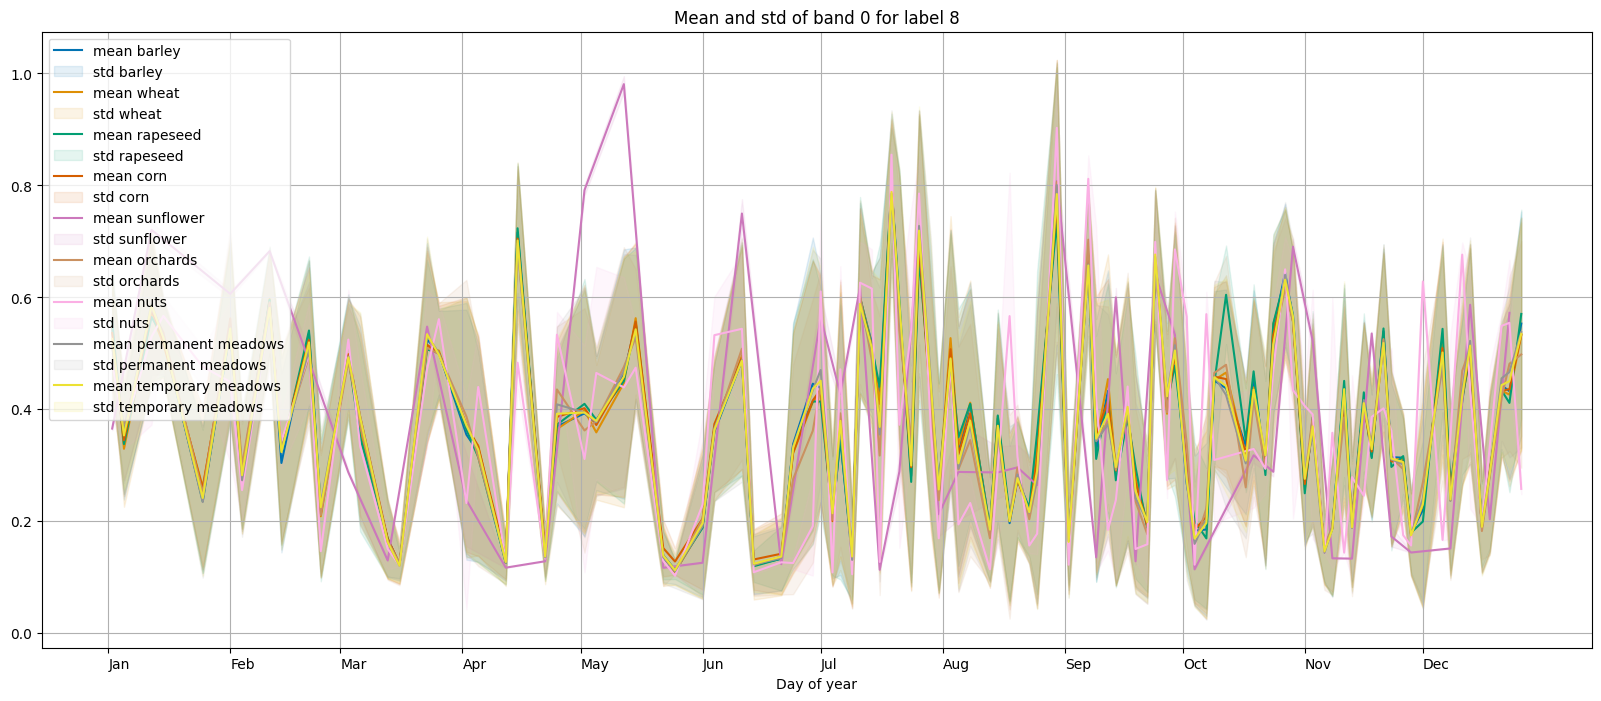

In [116]:
fig, ax = plt.subplots(figsize=(20,8))
band = 0 

for label_y, class_name in enumerate(class_names):
    print(f"computing for label: {label_y} (class: {class_name})")
    mean_std_per_day = get_mean_std_per_day(df, label_y, band)
    fig, ax = plot_mean_std_per_day(mean_std_per_day, label_y, band, fig, ax, label_string=f" {class_name}", color=PALETTE[label_y], alpha=0.1)